<font size="+3"><strong>Predicting Price with Everything</strong></font>

In [ ]:
import warnings
from glob import glob

import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline

warnings.simplefilter(action="ignore", category=FutureWarning)

# Prepare Data

# Import

In [ ]:
def wrangle(filepath):
    #import_csv
    df = pd.read_csv(filepath,index_col=[0])

    #subset to propertes in '"Capital Federal"'
    mask_ba= df["place_with_parent_names"].str.contains("Bogotá D.C")

    #subset for  '"apartment"'
    mask_apt=df["property_type"] == "house"

    #subset where '"price_aprox_usd"' < 400,000
    mask_price= df["price_aprox_usd"] < 400_000

    df= df[mask_ba & mask_apt & mask_price]

    #Remove the outliers by '"surface_covered_in_m2"'
    low, high= df["surface_covered_in_m2"].quantile([0.1,0.9])
    mask_area =df["surface_covered_in_m2"].between(low, high)
    df=df[mask_area]

    #split the '"lat-lon"'
    df[["lat" ,"lon"]]= df["lat-lon"].str.split(",", expand= True).astype(float)
    df.drop(columns="lat-lon", inplace = True)

    #Extract neighborhood
    df["neighborhood"]= df["place_with_parent_names"].str.split("|",expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace= True)

    return df

In [ ]:
# Create a list that contains the filenames for all real estate CSV files
files = glob("/content/colombia-real-estate-*.csv")
files

['/content/colombia-real-estate-1.csv',
 '/content/colombia-real-estate-2.csv',
 '/content/colombia-real-estate-4.csv',
 '/content/colombia-real-estate-5.csv',
 '/content/colombia-real-estate-3.csv']

In [ ]:
# Create a list named `frames`
frames = [wrangle(file) for file in files]

In [ ]:
# Concatenate the items in `frames` into a single DataFrame `df`
df = pd.concat(frames, ignore_index= True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4126 entries, 0 to 4125
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   4126 non-null   object 
 1   property_type               4126 non-null   object 
 2   price                       4126 non-null   float64
 3   currency                    4126 non-null   object 
 4   price_aprox_local_currency  4126 non-null   float64
 5   price_aprox_usd             4126 non-null   float64
 6   surface_total_in_m2         1688 non-null   float64
 7   surface_covered_in_m2       4126 non-null   float64
 8   price_usd_per_m2            1688 non-null   float64
 9   price_per_m2                4126 non-null   float64
 10  floor                       2704 non-null   float64
 11  rooms                       3352 non-null   float64
 12  expenses                    1 non-null      float64
 13  properati_url               4126 

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
0,sell,house,6.300000e+08,COP,6.349309e+08,212721.41,NaN,135.0,NaN,4.666667e+06,NaN,3.0,NaN,http://usaquen-bogota-d-c.properati.com.co/jm3...,4.724,-74.023,Usaquén
1,sell,house,5.000000e+08,COP,5.039134e+08,168826.52,NaN,240.0,NaN,2.083333e+06,NaN,3.0,NaN,http://los-martires-bogota-d-c.properati.com.c...,4.618,-74.081,Los Mártires
2,sell,house,3.950000e+08,COP,3.980916e+08,133372.95,NaN,134.0,NaN,2.947761e+06,NaN,3.0,NaN,http://suba-bogota-d-c.properati.com.co/jm4g_v...,4.729,-74.053,Suba
3,sell,house,1.100000e+09,COP,1.108609e+09,371418.34,NaN,143.0,NaN,7.692308e+06,NaN,3.0,NaN,http://usaquen-bogota-d-c.properati.com.co/jm4...,4.667,-74.050,Usaquén
4,sell,house,7.000000e+08,COP,7.054787e+08,236357.12,NaN,248.0,NaN,2.822581e+06,2.0,4.0,NaN,http://suba-bogota-d-c.properati.com.co/jm5d_v...,4.702,-74.060,Suba


## Explore

In [ ]:
# Check null values
df.isnull().sum() / len(df)

operation                     0.000000
property_type                 0.000000
price                         0.000000
currency                      0.000000
price_aprox_local_currency    0.000000
price_aprox_usd               0.000000
surface_total_in_m2           0.590887
surface_covered_in_m2         0.000000
price_usd_per_m2              0.590887
price_per_m2                  0.000000
floor                         0.344644
rooms                         0.187591
expenses                      0.999758
properati_url                 0.000000
lat                           0.000000
lon                           0.000000
neighborhood                  0.000000
dtype: float64

In [ ]:
# Drop features with high null counts
df.drop(columns = ["floor","expenses"], inplace= True)

In [ ]:
# Calculate the number of unique values for each non-numeric features
df.select_dtypes("object").nunique()

operation           2
property_type       1
currency            1
properati_url    4126
neighborhood       20
dtype: int64

In [ ]:
#Drop low and high cardinality categorical features
df.drop(columns= ["operation", "property_type", "currency","properati_url"], inplace=True)

In [ ]:
#Drop Leakey columns
df.drop(columns= [
                  "price",
                  "price_aprox_local_currency",
                  "price_per_m2",
                  "price_usd_per_m2"
                 ],
  inplace= True)

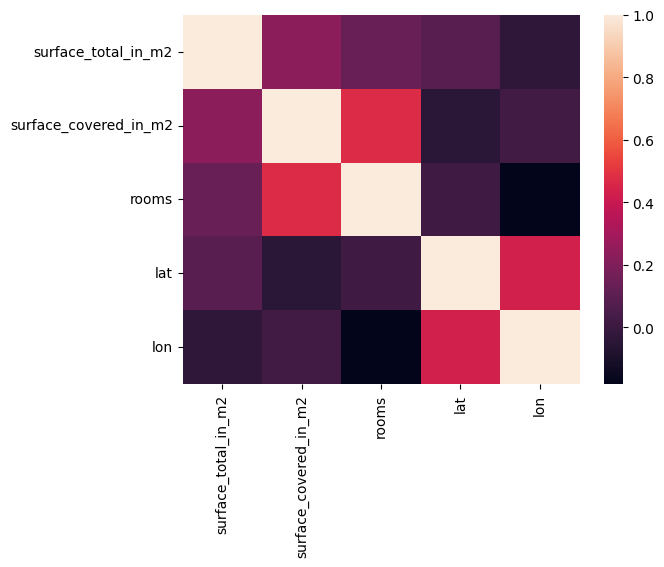

In [ ]:
# Correlation heatmap of the remaining numerical features
corr = df.select_dtypes("number").drop(columns= "price_aprox_usd").corr()
sns.heatmap(corr);

In [ ]:
#Drop columns with multicollinearity
df.drop(columns=["surface_total_in_m2", "rooms"], inplace=True)

The final version of our wrangle function and DataFrame:

In [ ]:
def wrangle(filepath):
    #import_csv
    df = pd.read_csv(filepath,index_col=[0])

    #subset to propertes in '"Capital Federal"'
    mask_ba= df["place_with_parent_names"].str.contains("Bogotá D.C")

    #subset for  '"apartment"'
    mask_apt=df["property_type"] == "house"

    #subset where '"price_aprox_usd"' < 400,000
    mask_price= df["price_aprox_usd"] < 400_000

    df= df[mask_ba & mask_apt & mask_price]

    #Remove the outliers by '"surface_covered_in_m2"'
    low, high= df["surface_covered_in_m2"].quantile([0.1,0.9])
    mask_area =df["surface_covered_in_m2"].between(low, high)
    df=df[mask_area]

    #split the '"lat-lon"'
    df[["lat" ,"lon"]]= df["lat-lon"].str.split(",", expand= True).astype(float)
    df.drop(columns="lat-lon", inplace = True)

    #Extract neighborhood
    df["neighborhood"]= df["place_with_parent_names"].str.split("|",expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace= True)

    # Drop features with high null counts
    df.drop(columns = ["floor","expenses"], inplace= True)
    #Drop low and high cardinality categorical variables
    df.drop(columns= ["operation", "property_type", "currency","properati_url"], inplace=True)
    #Drop Leakey columns
    df.drop(columns= [
                      "price",
                      "price_aprox_local_currency",
                      "price_per_m2",
                      "price_usd_per_m2"
                    ],
    inplace= True)
    #Drop columns with multicollinearity
    df.drop(columns=["surface_total_in_m2", "rooms"], inplace=True)

    return df

In [ ]:
files = glob("/content/colombia-real-estate-*.csv")
frames = [wrangle(file) for file in files]
df = pd.concat(frames, ignore_index= True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4126 entries, 0 to 4125
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        4126 non-null   float64
 1   surface_covered_in_m2  4126 non-null   float64
 2   lat                    4126 non-null   float64
 3   lon                    4126 non-null   float64
 4   neighborhood           4126 non-null   object 
dtypes: float64(4), object(1)
memory usage: 161.3+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,212721.41,135.0,4.724,-74.023,Usaquén
1,168826.52,240.0,4.618,-74.081,Los Mártires
2,133372.95,134.0,4.729,-74.053,Suba
3,371418.34,143.0,4.667,-74.050,Usaquén
4,236357.12,248.0,4.702,-74.060,Suba


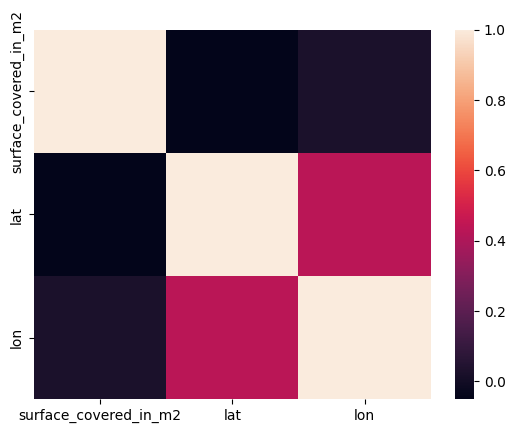

In [ ]:
corr = df.select_dtypes("number").drop(columns= "price_aprox_usd").corr()
sns.heatmap(corr);

## Split

In [ ]:
# Split `df` into feature matrix and target vector
target = "price_aprox_usd"
features = ["surface_covered_in_m2", "lat", "lon", "neighborhood"]
X_train= df[features]
y_train = df[target]

# Build Model

## Baseline

In [ ]:
# Calculate the baseline mean absolute error
y_mean= y_train.mean()
y_pred_baseline =[y_mean] * len(y_train)
print("Mean house price:", round(y_mean, 2))
print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean house price: 66403.66
Baseline MAE: 86347.16145862668


## Iterate

In [ ]:
# pipeline contains a `OneHotEncoder`, `SimpleImputer`, and `Ridge` predictor
model = make_pipeline(
           OneHotEncoder(use_cat_names=True),
           SimpleImputer(),
           Ridge()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

## Evaluate

In [ ]:
# Calculate the training mean absolute error
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train, y_pred_training))

Training MAE: 84203.94103184581


# Results

In [ ]:
# Create a function returns our model’s prediction for an house price
def make_prediction(area, lat, lon, neighborhood):
  data = {
  "surface_covered_in_m2" :area,
  "lat": lat,
  "lon": lon,
  "neighborhood": neighborhood
  }
  df = pd.DataFrame(data, index = [0])
  prediction = model.predict(df).round(2)[0]
  return f"Predicted house price: ${prediction}"

In [ ]:
make_prediction(160, 4.715, -74.095, "Suba")

'Predicted house price: $90081.74'

In [ ]:
# Creating an interactive dashboard, where a user can supply values and receive a prediction
interact(
    make_prediction,
    area=IntSlider(
          min=X_train["surface_covered_in_m2"].min(),
          max=X_train["surface_covered_in_m2"].max(),
          value=X_train["surface_covered_in_m2"].mean(),
),

    lat=FloatSlider(
         min=X_train["lat"].min(),
         max=X_train["lat"].max(),
         step=0.01,
         value=X_train["lat"].mean(),
),

    lon=FloatSlider(
         min=X_train["lon"].min(),
         max=X_train["lon"].max(),
         step=0.01,
         value=X_train["lon"].mean(),
),

    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

interactive(children=(IntSlider(value=135, description='area', max=495, min=45), FloatSlider(value=4.687857965…